<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./211_ltpy_v01_AC_SAF_L2_data.ipynb"><< 211 - AC SAF - NRT and offline (Level 2) products </a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./22_ltpy_v01_AC_SAF_L3_data_products.ipynb">22 - AC SAF Data records (Level 3) >></a>

# 2.1.2 AC SAF - Level 2 data pre-processing

The previous module 2.1.1 showed how AC SAF Level 2 data can be loaded and visualized. Unfiltered AC SAF Levle 2 data may contain negative values and measurements can further be influenced by clouds. Thus, there are some pre-processing steps required to mask the data and filter invalide ground pixels. 

This module show how AC SAF Level 2 data can be masked, how data from Metop-A and Metop-B can be combined and how a geographical subset can be selected.

#### This module has the following outline:
* [1 - Data masking](#masking)
* [2 - Combine Metop-A and Metop-B data files](#metop_ab)
* [3 - Select geographical subset](#subset)

#### Load required libraries

In [2]:
import os
import h5py
from netCDF4 import Dataset, MFDataset
import xarray as xr
import numpy as np
import pandas
import datetime

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output

#### Helper functions

In [3]:
def load_l2_data_xr(directory, internal_filepath, parameter, longname, unit, name):
    fileList = os.listdir(directory)
    datasets = []

    for i in fileList:
        fullpath=os.path.join(directory, i)
        tmp = h5py.File(fullpath, 'r')
        groups =tmp.keys()
        tmp[internal_filepath]
        latitude = tmp['GEOLOCATION/LatitudeCentre']
        longitude = tmp['GEOLOCATION/LongitudeCentre']
        param = tmp[internal_filepath+'/'+parameter]
        da_tmp = xr.DataArray(
            param[()],
            dims=('ground_pixel'),
            coords={
                'latitude': ('ground_pixel', latitude[:]),
                'longitude': ('ground_pixel', longitude[:])
            },
            attrs={'long_name': longname, 'units': unit},
            name=name
        )
        datasets.append(da_tmp)

    return xr.concat(datasets, dim='ground_pixel')

In [13]:
def visualize_gome_mollweide(xr_dataarray, conversion_factor, color_scale, vmin, vmax):
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=ccrs.Mollweide())

    ax.coastlines()
    ax.set_global()

    ax.gridlines(linestyle='--')
    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

In [28]:
def visualize_gome_l2(xr_dataarray, conversion_factor, projection, vmin, vmax, color_scale,set_global=False):
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=projection)

    ax.coastlines()
    if set_global:
        ax.set_global()

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

<hr>

### Load multi-file `DataArray`

In [4]:
directory_2a = './eodata/gome2/offline/2a//2019/08/18/'
no2_a_da_mf = load_l2_data_xr(directory_2a, 'TOTAL_COLUMNS', 'NO2Tropo', 'Tropospheric column density of NO2', 'mol/cm2', 'tropospheric_NO2')
no2_a_da_mf

<xarray.DataArray 'tropospheric_NO2' (ground_pixel: 223224)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.854996 64.1843 ... -63.2107 -63.55267
    longitude  (ground_pixel) float32 323.52814 323.20117 ... 343.05618
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2

## <a id="masking"></a>Data masking

AC SAF Level 2 data provide valuable information on the quality and validity of the measured data. Different conditions can influence the measured values:
* Negative values can occur, which are not valid
* Clouds fractions influence the measured values and lead to errors, and
* other conditions that might make the measured data invalid, e.g. an unsuccessful fitting of the slant column.

Thus, we have to mask the ground pixels that are valid.

### Flag negative values

Negative values can simply flagged by casting the `DataArray` for only positive values.

In [8]:
no2_a_da_mf_flagged = no2_a_da_mf[no2_a_da_mf > 0]

print(no2_a_da_mf_flagged, no2_a_da_mf_flagged.min())

<xarray.DataArray 'tropospheric_NO2' (ground_pixel: 50266)>
array([2.830912e+14, 1.655076e+13, 2.572588e+13, ..., 4.655350e+14,
       1.002884e+15, 1.428212e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.99267 69.67526 ... -53.28818 -53.63702
    longitude  (ground_pixel) float32 186.07918 185.59663 ... 348.81454
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2 <xarray.DataArray 'tropospheric_NO2' ()>
array(5.099747e+10, dtype=float32)


<br>

We see that the minimum of our `DataArray` is not negative anymore. Visualizing the `DataArray` shows a more detailed representation of the total column NO<sub>2</sub>. Filtering simply the negative values is just one part. Another important part to filter invalid pixels is to mask all ground pixels that are covered with clouds.

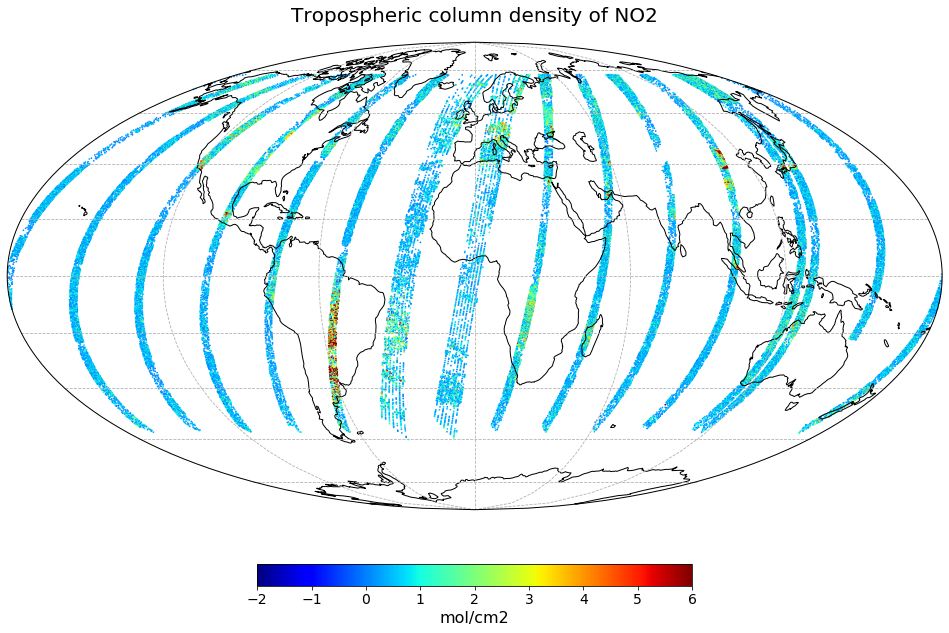

In [30]:
visualize_gome_mollweide(no2_a_da_mf_flagged, 1e-15, 'jet', vmin=-2, vmax=6)

### Cloud masking

AC SAF Level 2 data provide under the `CLOUD_PROPERTIES` group information on the `CloudFraction` for each ground pixel. The first step is to generate a cloud mask we can apply to our total column data array. We therefore load the cloud fraction property with the `load_l2_data_xr` function.

In [15]:
cloud_fraction_2a = load_l2_data_xr(directory_2a, 'CLOUD_PROPERTIES', 'CloudFraction', unit='-', longname='Cloud Fraction', name='cloud_fraction')
cloud_fraction_2a

<xarray.DataArray 'cloud_fraction' (ground_pixel: 223224)>
array([0.724346, 0.727695, 0.708963, ..., 0.760661, 0.729901, 0.659259],
      dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.854996 64.1843 ... -63.2107 -63.55267
    longitude  (ground_pixel) float32 323.52814 323.20117 ... 343.05618
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

With xarray's function `where`, we can generate a cloud mask, by specifying e.g. each ground pixel with a `CloudFraction` higher than 50% to classify as unvalid (mask value = 0). The resulting mask has value 1 for ground pixels we want to keep and value 0 for ground pixels we want to drop. Xarray's `where` function further helps to apply the cloud mask to our `DataArray`. We want to keep the ground pixels where the cloud mask is 1 and we want to drop the rest.

The function `generate_masked_array` combines all steps of `cloud masking`. The masked array, where negative values were filtered out, is returned. We see that the number of valid ground pixels decreased from over 200 000 to less than 140 000.

In [16]:
def generate_masked_array(xarray, mask, threshold):
    cloud_mask = xr.where(mask < threshold, 1, 0) #Generate cloud mask with value 1 for the pixels we want to keep
    xarray_masked = xr.where(cloud_mask ==1, xarray, 0) #Apply mask onto the DataArray
    xarray_masked.attrs = xarray.attrs #Set DataArray attributes 
    return xarray_masked[xarray_masked > 0] #Return masked DataArray and flag negative values

In [17]:
no2_a_da_masked = generate_masked_array(no2_a_da_mf, cloud_fraction_2a, 0.5)
no2_a_da_masked

<xarray.DataArray (ground_pixel: 50264)>
array([2.830912e+14, 1.655076e+13, 2.572588e+13, ..., 4.655350e+14,
       1.002884e+15, 1.428212e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.99267 69.67526 ... -53.28818 -53.63702
    longitude  (ground_pixel) float32 186.07918 185.59663 ... 348.81454
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2

<br>

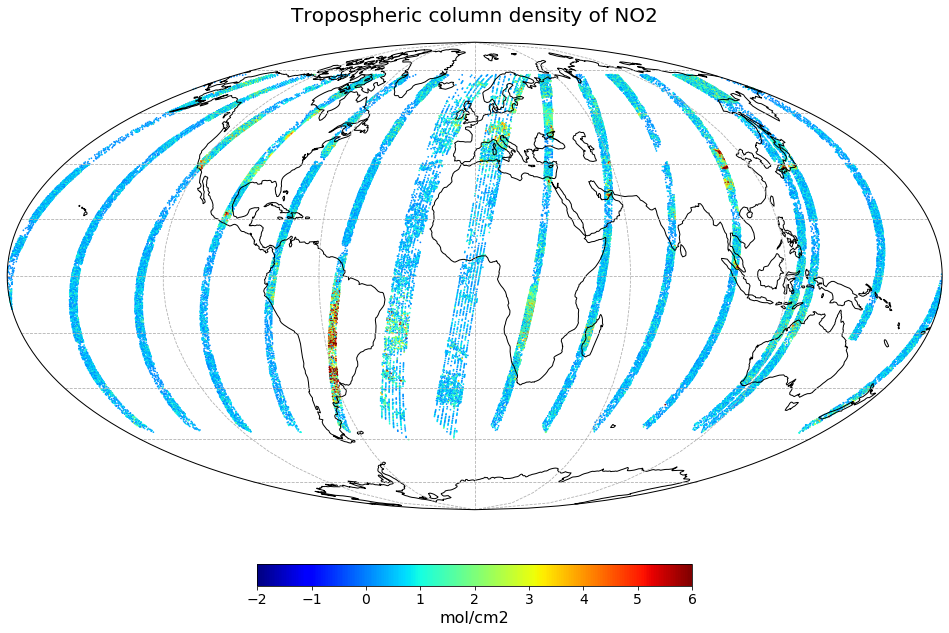

In [31]:
visualize_gome_mollweide(no2_a_da_masked, 1e-15, 'jet', vmin=-2, vmax=6)

<br>

## <a id="metop_ab"></a>Combine Metop-A and Metop-B data files

The above examples show that Metop-A data have many parts on Earth unsensed. Metop-A data can be combined with Metop-B ground pixels for one specific day in order to increase the overall coverage. Metop-B has a wider nominal resolution than Metop-A.

Since we already concatenated and filtered the ground pixel values for day 18 Aug 2019 for Metop-A GOME Level 2 data, we only have to repeat the same pre-processing steps for the Metop-B data files:

1. Load total column NO<sub>2</sub> values with `load_l2_data_xr` function 
2. Load cloud fraction information with `load_l2_data_xr` function
3. Filter unvalid ground pixels with `generate_masked_array`
4. Visualize the masked array with `visualize_gome_mollweide`.

#### 1. Load total column NO<sub>2</sub> values from MetOp-B

In [19]:
directory_2b= './eodata/gome2/offline/2b/2019/08/18/'
no2_b_da_mf = load_l2_data_xr(directory_2b, 'TOTAL_COLUMNS', 'NO2Tropo', 'Tropospheric column density of NO2', 'mol/cm2','vertical_column_NO2')
no2_b_da_mf

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 211316)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 62.9539 63.253677 ... -67.50761 -67.852005
    longitude  (ground_pixel) float32 300.33945 299.89417 ... 26.373968
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2

<br>

#### 2. Load cloud fraction information

In [20]:
cloud_fraction_2b = load_l2_data_xr(directory_2b,'CLOUD_PROPERTIES','CloudFraction',unit='-', longname='Cloud Fraction', name='cloud_fraction') 
cloud_fraction_2b

<xarray.DataArray 'cloud_fraction' (ground_pixel: 211316)>
array([1.      , 1.      , 1.      , ..., 0.594206, 0.603546, 0.646609],
      dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 62.9539 63.253677 ... -67.50761 -67.852005
    longitude  (ground_pixel) float32 300.33945 299.89417 ... 26.373968
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

#### 3. Mask data array

In [21]:
no2_b_da_masked = generate_masked_array(no2_b_da_mf, cloud_fraction_2b, 0.5)
no2_b_da_masked

<xarray.DataArray (ground_pixel: 45052)>
array([1.316263e+15, 1.913808e+15, 9.571219e+14, ..., 6.898217e+14,
       7.350718e+14, 1.586071e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.88516 69.6914 ... -57.549297 -58.02928
    longitude  (ground_pixel) float32 307.11572 306.23364 ... 27.981504
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2

<br>

#### 4. Visualization of masked MetOp-B Total column NO2 ground pixels

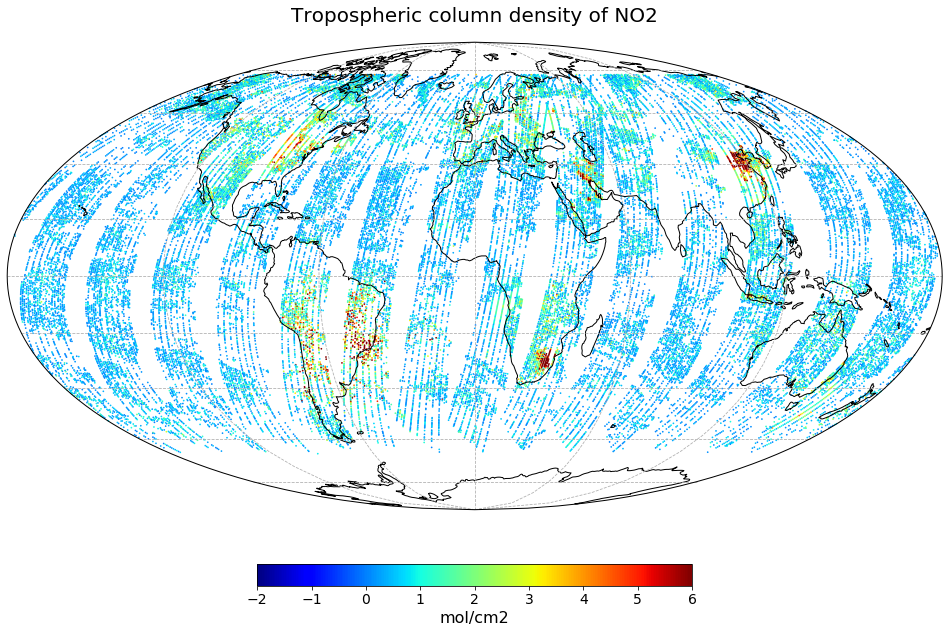

In [32]:
visualize_gome_mollweide(no2_b_da_masked, 1e-15, 'jet', vmin=-2, vmax=6)

<br>

### Combine masked `DataArrays` with `xarray.concat`

To combine data from Metop-A and Metop-B, we have to concatenate both `DataArrays` with `xarray.concat`. The resulting `DataArray` object has more than 250 000 ground pixel values. With the `visualize_gome_mollweide` function, we can visualize the combined `DataArray`.

In [23]:
no2_ab_da_masked = xr.concat([no2_a_da_masked, no2_b_da_masked], dim='ground_pixel')
no2_ab_da_masked

<xarray.DataArray (ground_pixel: 95316)>
array([2.830912e+14, 1.655076e+13, 2.572588e+13, ..., 6.898217e+14,
       7.350718e+14, 1.586071e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.99267 69.67526 ... -57.549297 -58.02928
    longitude  (ground_pixel) float32 186.07918 185.59663 ... 27.981504
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2

<br>

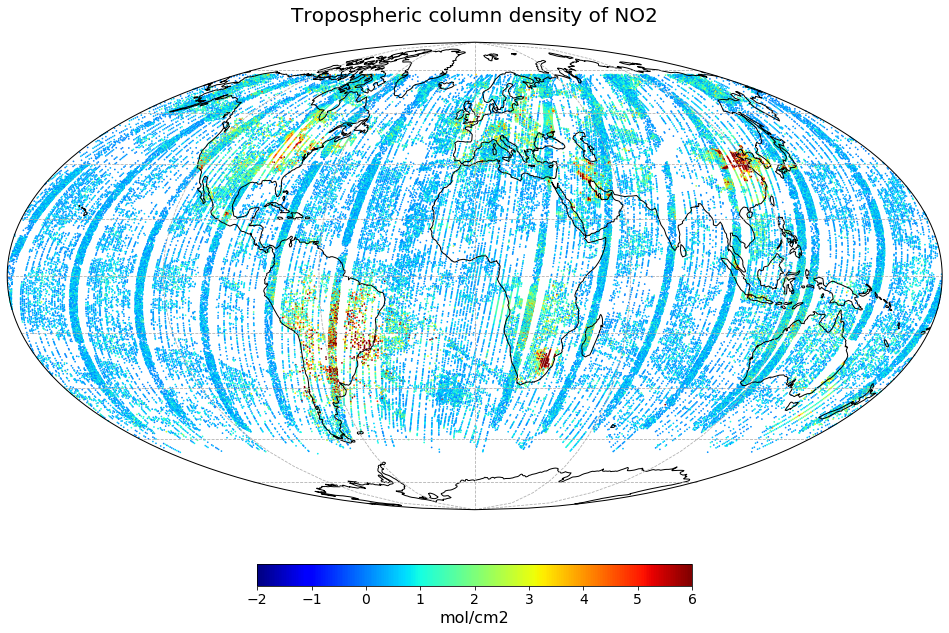

In [33]:
visualize_gome_mollweide(no2_ab_da_masked, 1e-15, 'jet', vmin=-2, vmax=6)

<br>

## <a id="subset"></a>Select geographical subset

We can generate a `geographical subset` of our `DataArray` to get a closer look at one specific region. The subset can easily be created with xarray's function `where`. We can assigne for `latitude` and `longitude` a minimum and maximum threshold. By using the `drop` argument, we drop the data values for wich the condition is False.

There is one caveat: the `longitude` values of the AC SAF Level 2 data are stored as 0 to 360-degrees longitude. Thus, if we want to select the geographical subset based on a geographical bounding box of -180 to 180 degrees, we have to convert the `longitude` values first. This is done by newly assigning the `longitude` values with the `assign_coords` function.

In [25]:
no2_ab_da_masked = no2_ab_da_masked.assign_coords(longitude=(((no2_ab_da_masked.longitude + 180) % 360) - 180))

#### Select the bounding box with xarray's `where` function

Let's select a bounding box over South America and parts of Central and Southern Africa with the following latitude and longitude boundaries:
* `latitude`: -60 deg to 15 deg
* `longitude`: -80 deg to 40 deg

In [26]:
no2_ab_da_subset = no2_ab_da_masked.where((no2_ab_da_masked.latitude < 15) & (no2_ab_da_masked.latitude > -60) & (no2_ab_da_masked.longitude < 40) & (no2_ab_da_masked.longitude > -80),drop=True)
no2_ab_da_subset

<xarray.DataArray (ground_pixel: 15813)>
array([7.697677e+14, 2.834878e+14, 1.050716e+15, ..., 6.898217e+14,
       7.350718e+14, 1.586071e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 14.749168 14.826208 ... -58.02928
    longitude  (ground_pixel) float32 -48.140686 -48.75055 ... 27.981506
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2

<br>

We can now visualize the geographic subset with the defined function `visualize_gome_l2`, which represents the subset in a `PlateCarree` projection.

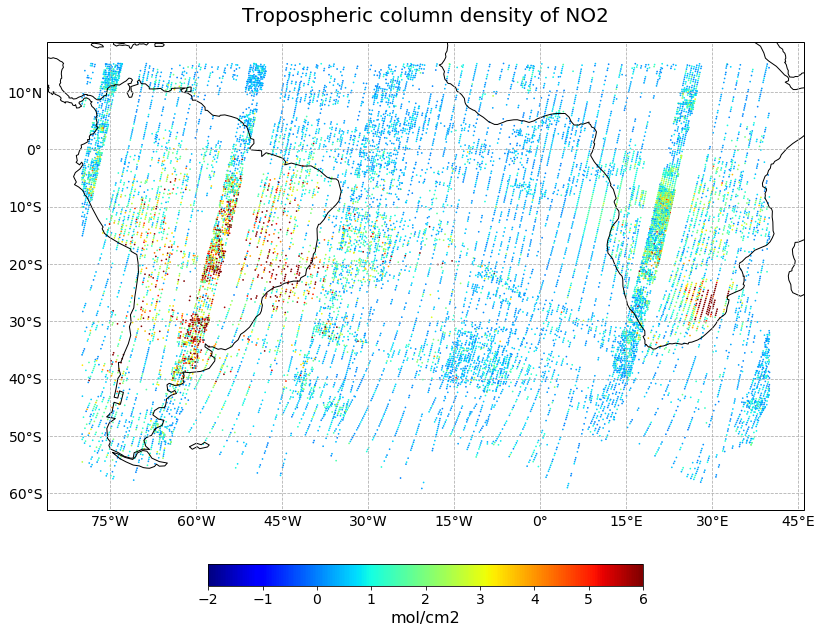

In [34]:
visualize_gome_l2(no2_ab_da_subset, 1e-15, ccrs.PlateCarree(), vmin=-2,vmax=6, color_scale='jet', set_global=False)

<hr>

<p style="text-align:left;"><a href="./LICENSE">&copy; Copyright 2019 eo-lab</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>